In [13]:
!pip install geomle
!pip install mnist
!pip install emnist

In [70]:
import sys
import os
from os import path
current_folder = path.dirname(path.abspath('')) 
sys.path.append(current_folder)
from estimators import *
from geomle import geomle, mle, DataGenerator
import multiprocessing as mp
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from scipy.linalg import cholesky
from scipy.special import gammainc, lambertw
from sklearn.datasets import fetch_openml
import mnist as mnist_api
import emnist as emnist_api
import scipy.io
import matplotlib as mpl
from matplotlib import pyplot as plt
import umap
import seaborn as sns
import random
import time
import numpy as np
import pandas as pd
import pickle
import rpy2
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
import rpy2.robjects.packages as rpackages
from functools import wraps
import subprocess
from IPython.display import display_html
from operator import itemgetter
ig0 = itemgetter(0)
ig1 = itemgetter(1)
ig2 = itemgetter(2)
rpy2.robjects.numpy2ri.activate()
utils = rpackages.importr('utils')
#utils.install_packages('intrinsicDimension')
#utils.install_packages('ider')
intdimr = rpackages.importr('intrinsicDimension')
ider   = rpackages.importr('ider')
r_base = rpackages.importr('base')

In [2]:
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

def mean_sqe(estimations, truth):
    '''
    Mean squared error 
    '''
    return ((estimations - truth)^2/truth).sum() /len(truth) 
    
def mean_pe(estimations, truth):
    '''
    Mean percentage error 
    '''
    return (abs(estimations - truth)/truth).sum() /len(truth)*100

def mean_ge(estimations, truth):
    '''
    Mean geometric error: The geometric mean of the error *ratio*. It is always >= 1.
    '''
    ratios = np.concatenate(((estimations/truth)[np.newaxis, :], (truth/estimations)[np.newaxis, :]), axis=0)
    return np.power(ratios.max(axis=0).prod(), 1.0/len(estimations))

def med_pe(estimations, truth):
    '''
    Median error in %.
    '''
    return np.percentile(abs(estimations - truth)/truth, q=50)*100


def randball(n_points,ndim,radius,center = []):
    ''' Generate uniformly sampled ndim-sphere interior'''
    if center == []:
        center = np.array([0]*ndim)
    r = radius
    x = np.random.normal(size=(n_points, ndim))
    ssq = np.sum(x**2,axis=1)
    fr = r*gammainc(ndim/2,ssq/2)**(1/ndim)/np.sqrt(ssq)
    frtiled = np.tile(fr.reshape(n_points,1),(1,ndim))
    p = center + np.multiply(x,frtiled)
    return p, center

def proxy(tup):
    function,X,Dict = tup
    return function(X,**Dict)

def get_nn(X,k,n_jobs=1):
    neigh = NearestNeighbors(n_neighbors=k,n_jobs=n_jobs)
    neigh.fit(X)
    dists, inds = neigh.kneighbors(return_distance=True)
    return dists,inds

def asPointwise(data,function, params, precomputed_knn = None, n_neighbors=100, n_jobs=1):
    '''Use a global estimator as a pointwise one by creating kNN neighborhoods'''
    if precomputed_knn is not None:
        knn = precomputed_knn
    else:
        _, knn = get_nn(data, k=n_neighbors, n_jobs=n_jobs)
        
    if n_jobs > 1:
        pool = mp.Pool(n_jobs)
        results = pool.map(proxy,[(function,data[i,:],params) for i in knn])
        pool.close()
        return results
    else:
        return [function(data[i,:],**params) for i in knn]

def point_inseparability_to_pointID(n_alpha,n_single,p_alpha,alphas,idx='all_separable'):
    '''
    idx : int, string
        Int for custom alpha index
        'all_separable' to choose alpha where lal points have non-zero inseparability probability
        'selected' to keep global alpha selected
    
    '''
    if idx == 'all_separable': #all points are separable
        selected_idx = np.argwhere(np.all(p_alpha!=0,axis=1)).max()
    elif idx == 'selected': #
        selected_idx = (n_alpha==n_single).tolist().index(True)   
    elif idx == int:
        selected_idx = idx
    else:
        raise ValueError('unknown idx parameter')
        
    palpha_selected = p_alpha[selected_idx,:]
    alpha_selected = alphas[0,selected_idx]
    
    
    py=palpha_selected
    alphas=np.repeat(alpha_selected,len(palpha_selected))[None]
    
    if len(py)!=len(alphas[0,:]):
        raise ValueError('length of py (%i) and alpha (%i) does not match'%(len(py),len(alphas[0,:])))

    if np.sum(alphas <= 0) > 0 or np.sum(alphas >= 1) > 0:
        raise ValueError(['"Alphas" must be a real vector, with alpha range, the values must be within (0,1) interval'])

    #Calculate dimension for each alpha
    n = np.zeros((len(alphas[0,:])))
    for i in range(len(alphas[0,:])):
        if py[i] == 0:
            #All points are separable. Nothing to do and not interesting
            n[i]=np.nan
        else:
            p  = py[i]
            a2 = alphas[0,i]**2
            w = np.log(1-a2)
            n[i] = lambertw(-(w/(2*np.pi*p*p*a2*(1-a2))))/(-w)

    n[n==np.inf] = float('nan')
    #Find indices of alphas which are not completely separable 
    inds = np.where(~np.isnan(n))[0]
    print(str(len(inds))+'/'+str(len(py)),'points have nonzero inseparability probability for chosen alpha =',alpha_selected)
    return n, inds

from functools import wraps
def calculate_time(func): 
    @wraps(func)
    def inner_func(*args, **kwargs): 
        begin = time.time() 
        res = func(*args, **kwargs) 
        end = time.time()
        return res, end - begin
    return inner_func

class DimEst():
    def __init__(self):
        self.names = ['MLE', 'GeoMLE', 'MIND', 'DANCo', 'FastDANCo', 'ESS', 'PCA', 'CD','FisherS','ANOVA','TwoNN']
        self.caldatas = {}
        
    def estimateAllMethods(self, data):
        dim = data.shape[1]
        self.funcs = {'MLE':          self.mle(data),
                      #'GeoMLE':       self.geomle(data, dim),
                      'MiND':         self.mind_mlk(data, dim),
                      #'DANCo':        self.danco(data, dim),
                      'FastDANCo':    self.fast_danco(data),
                      'ESS':          self.ess(data),
                      #'PCA':          self.pca(data),
                      #'CD':           self.cd(data),
                      'FisherS':      self.fisherS(data),
                      'ANOVA':        self.anova(data),
                      'TwoNN':        self.twonn(data)
                     }
                      
        self.times = {key: ig1(val) for key, val in self.funcs.items()}
        self.funcs = {key: ig0(val) for key, val in self.funcs.items()}
        return self.funcs, self.times
    
    def estimateAllMethodsLocally(self, data, k, n_jobs = 1):
        dim = data.shape[1]
        
        _, knn = get_nn(data, k, n_jobs)
        
        self.funcs = {'MLE':          self.mlelocal(data,k),
                      #'GeoMLE':       self.geomle(data, dim),
                      'MiND':         asPointwise(data,self.mind_mlk,{'dim':dim},precomputed_knn=knn,n_jobs=1),
                      #'DANCo':        asPointwise(data,self.danco,{'dim':dim},precomputed_knn=knn,n_jobs=1),
                      'FastDANCo':    self.fast_dancoloop(data),
                      'ESS':          asPointwise(data,self.ess,{},precomputed_knn=knn,n_jobs=1),
                      #'PCA':          self.pca(data),
                      #'CD':           self.cd(data),
                      'FisherS':      asPointwise(data,self.fisherS,{},precomputed_knn=knn,n_jobs=n_jobs),
                      'ANOVA':        self.anovalocal(data,k),
                      'TwoNN':        asPointwise(data,self.twonn,{},precomputed_knn=knn,n_jobs=n_jobs)
                     }
                      
        self.times = {}
        for key, val in self.funcs.items():
            if key in ['MLE','ANOVA','FastDANCo']:
                self.funcs[key] = np.array(val[0])
                self.times[key] = val[1]
            else:
                self.funcs[key] = np.array([i[0] for i in val])
                self.times[key] = np.sum([i[1] for i in val])
            
        return self.funcs, self.times
    
    @staticmethod
    @calculate_time
    def mle(data):
        return intdimr.maxLikGlobalDimEst(data,k=20).rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def mlelocal(data,k):
        res = intdimr.maxLikPointwiseDimEst(data,k=k)
        return np.array([i[0] for i in res])

    @staticmethod
    @calculate_time
    def geomle(data, dim):
#         k1 =  k1_log(dim)
#         k2 =  k2_log(dim)
        return geomle(pd.DataFrame(data), k1=20, k2=55, nb_iter1=1, alpha=5e-3).mean()
    
    @staticmethod
    @calculate_time
    def mind_mlk(data, dim):
        return intdimr.dancoDimEst(data, k=10, D=min(dim,100), ver="MIND_MLk").rx2('dim.est')[0]
    
    #@staticmethod
    @calculate_time
    def danco(self,data, dim):
        try:
            res = intdimr.dancoDimEst(data, k=10, D=min(dim,100), calibration_data = self.caldatas[len(data)], ver="DANCo")
            self.caldatas[len(data)]=res[2]
            return res.rx2('dim.est')[0]
        except:
            res = intdimr.dancoDimEst(data, k=10, D=min(dim,100), ver="DANCo")
            self.caldatas[len(data)]=res[2]
            return res.rx2('dim.est')[0]

    @staticmethod
    @calculate_time
    def fast_danco(data):
        return runDANCo(data)[0]
    
    @staticmethod
    @calculate_time
    def fast_dancoloop(data):
        return runDANColoop(data)
    
    @staticmethod
    @calculate_time
    def ess(data):
        return ess_py(data)[0]
    
    @staticmethod
    @calculate_time
    def pca(data):
        return intdimr.pcaLocalDimEst(data, 'FO').rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def cd(data):
        return corint_py(data, k1=10, k2=20)[0]
    
    @staticmethod
    @calculate_time
    def fisherS(data):
        return SeparabilityAnalysis(data,ProducePlots=0,alphas=np.arange(.2,1,.02)[None])[1][0]
    
    @staticmethod
    @calculate_time
    def anova(data):
        return runANOVAglobal(data)[0,0]
    
    @staticmethod
    @calculate_time
    def anovalocal(data,k):
        return runANOVAlocal(data,k=k)[:,0]
    
    @staticmethod
    @calculate_time
    def twonn(data):
        res = twonn_py(data)
        return res    

# Real data

In [109]:
DE=DimEst()

### Load full data to generate subsampled datasets

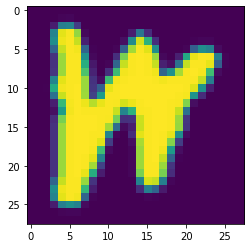

In [45]:
letters, emnist_labels = emnist_api.extract_training_samples('letters')
emnist = letters.reshape((len(letters),-1))
plt.imshow(letters[0])

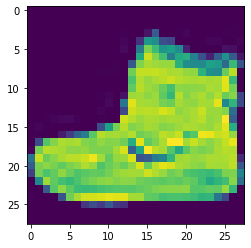

In [46]:
fashion_mnist=fetch_openml(name="Fashion-MNIST",data_home="../data")
fmnist = fashion_mnist['data']
fmnist_labels = fashion_mnist['target']
plt.imshow(fmnist[0].reshape(28,28))

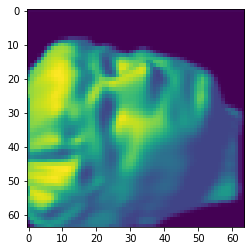

In [67]:
isomapFaces = scipy.io.loadmat('../data/face_data.mat')['images'].T
plt.imshow(isomapFaces[0].reshape((64,64)))

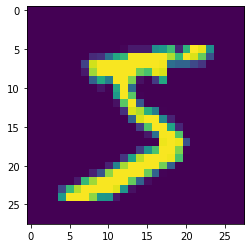

In [76]:
train_images, test_images = mnist_api.train_images(), mnist_api.test_images()
train_labels, test_labels = mnist_api.train_labels(), mnist_api.test_labels()

mnist = np.concatenate((train_images,test_images))
mnist = mnist_images.reshape((mnist.shape[0],-1))
mnist_labels = np.concatenate((train_labels,test_labels))

plt.imshow(train_images[0])

In [16]:
subsample_size = 5000
full_n_samples = mnist_images.shape[0]
np.random.seed(0);subsample = np.random.choice(full_n_samples,replace=False, size=subsample_size)
mnist_subsampled = mnist_images[subsample]
real_data_subsampled_idx = subsample
real_data_subsampled_labels = mnist_labels[subsample]
np.random.seed(0);umap_emb = umap.UMAP().fit_transform(mnist_subsampled)

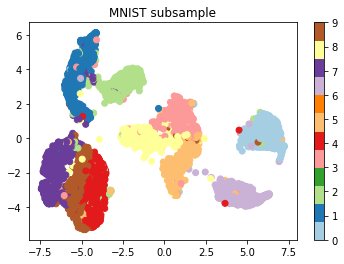

In [17]:
plt.scatter(umap_emb[:,0],umap_emb[:,1],c=real_data_subsampled_labels,cmap=plt.cm.Paired);plt.title('MNIST subsample');plt.colorbar();plt.show()

In [49]:
#load other data
data_files = list(filter(lambda x: '.data' in x and 'mnist' not in x, os.listdir('../data/id-tle-real-data/data/real/')))
real_data = [np.array(pd.read_csv('../data/id-tle-real-data/data/real/'+file,sep=' ',header=None)) for file in data_files]
real_data=dict(zip(data_files,real_data))

MemoryError: Unable to allocate array with shape (128, 1000000) and data type int64

In [ ]:
# gisette: handwritten digits (4 and 9) 2 classes
# mnist: handwritten digits (0 to 9) 10 classes
# msd: songs by various (mostly western) singers spanning several decades 90 classes
# aloi: Amsterdam Library of Object Images 1000 classes
# covertype: forest cover type (features: wilderness area, soil types) 7 classes
# isolet: 150 subjects spoke the name of each letter of the alphabet twice 26 classes
# ann_sift1b: 3·10^7 classes
# bci5: 3 classes

In [68]:
print('Real datasets used in Intrinsic Dimensionality Estimation within Tight Localities:\n')
for key,_data in real_data.items():
    print(key+'\t'+str(_data.shape))

Real datasets used in Intrinsic Dimensionality Estimation within Tight Localities:



NameError: name 'real_data' is not defined

In [5]:
# generate subsampled datasets
subsample_size = 5000

real_data_subsampled = {}
real_data_subsampled_idx = {}


for key,_data in real_data.items():
    dataset_name = key
    full_n_samples = _data.shape[0]
    
    
    if full_n_samples > subsample_size:
        np.random.seed(0)
        subsample = np.random.choice(full_n_samples,replace=False, size=subsample_size)
        real_data_subsampled[key] = _data[subsample]
        real_data_subsampled_idx[key] = subsample
    else:
        real_data_subsampled[key] = _data
        real_data_subsampled_idx[key] = None
        
        
with open('../data/real_data_subsampled.pkl','wb') as f:
    pickle.dump(real_data_subsampled,f)
with open('../data/real_data_subsampled_idx.pkl','wb') as f:
    pickle.dump(real_data_subsampled_idx,f)

In [6]:
#basic test
data = isomapFaces
results = DE.estimateAllMethods(data)
estimates = results[0]
runtimes = results[1]

estimates_table = pd.DataFrame(data=estimates.values(),index=estimates.keys(), columns=['isomapFaces'])
estimators_runtime = pd.DataFrame(data=runtimes.values(),index=runtimes.keys(), columns=['runtimes: isomapFaces'])
display_side_by_side(estimates_table,estimators_runtime)

,isomapFaces
MLE,4.001504
MiND,4.000000
FastDANCo,3.670166
ESS,7.444001
FisherS,3.871932
ANOVA,6.000000
TwoNN,3.605244
,runtimes: isomapFaces
MLE,2.122889
MiND,2.107293


# Run 

### Read subsampled datasets

In [4]:
# data values rescaled between -1 and 1
with open('../data/real_data_subsampled.pkl','rb') as f:
    real_data_subsampled = pickle.load(f)
with open('../data/real_data_subsampled_idx.pkl','rb') as f:
    real_data_subsampled_idx = pickle.load(f)

### Global ID saturation analysis

In [23]:
# testing separability saturation

n_repeats = 10
sample_sizes = [5,7,10,15,20,25,30,50,70,90]
sample_sizes_halves = [x/2 for x in sample_sizes]

all_sample_sizes = sample_sizes+sample_sizes_halves
all_sample_sizes = list(set(all_sample_sizes))
all_sample_sizes.sort()
np.random.seed(0)
#for key,data in real_data_subsampled.items():
for key,data in [('mnist',mnist_subsampled)]:

    dataset_name = key
    n_samples = data.shape[0]

    print(dataset_name)
    print('Running subsampling analysis...\nSubsample percentages = {}\nNumber of repeats = {}\nNumber of samples = {}\nDimension = {}'.format(sample_sizes,n_repeats,n_samples,data.shape[1]))
    print('----------------------------\n')

    fisherS_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
    ess_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
    danco_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
    twonn_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
    anova_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
    mle_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])
    mind_dim_estimates = np.empty([len(all_sample_sizes)+1,n_repeats])

    runtimes = []
    for i,sz in enumerate(all_sample_sizes):
        sample_size = int(n_samples*sz/100)
        print('Sample size = {}'.format(sample_size))
        start_time = time.time()
        for j in range(0,n_repeats):
            sample = np.random.choice(n_samples,replace=False, size=sample_size)
            xs = data[sample,:]

            #Run estimators
            allres = DE.estimateAllMethods(xs)
            results = allres[0]
            runtimes.append(allres[1])

            #Store
            fisherS_dim_estimates[i,j] = results['FisherS']
            ess_dim_estimates[i,j] = results['ESS']
            danco_dim_estimates[i,j] = results['FastDANCo']
            twonn_dim_estimates[i,j] = results['TwoNN']
            anova_dim_estimates[i,j] = results['ANOVA']
            mle_dim_estimates[i,j] = results['MLE']
            mind_dim_estimates[i,j] = results['MiND']


        print("Elapsed time = {}".format(time.time()-start_time))

    allres = DE.estimateAllMethods(data)
    results = allres[0]
    runtimes.append(allres[1])

    for i in range(0,n_repeats):
        fisherS_dim_estimates[len(all_sample_sizes),i] = results['FisherS']
        ess_dim_estimates[len(all_sample_sizes),i] = results['ESS']
        danco_dim_estimates[len(all_sample_sizes),i] = results['FastDANCo']
        twonn_dim_estimates[len(all_sample_sizes),i] = results['TwoNN']
        anova_dim_estimates[len(all_sample_sizes),i] = results['ANOVA']
        mle_dim_estimates[len(all_sample_sizes),i] = results['MLE']
        mind_dim_estimates[len(all_sample_sizes),i] = results['MiND']


    all_sample_sizes.append(100)
    sample_sizes.append(100)

    np.savetxt("../results/"+dataset_name+"_fisherS_dim_estimates.txt", fisherS_dim_estimates, delimiter="\t")
    np.savetxt("../results/"+dataset_name+"_ess_dim_estimates.txt", ess_dim_estimates, delimiter="\t")
    np.savetxt("../results/"+dataset_name+"_danco_dim_estimates.txt", danco_dim_estimates, delimiter="\t")
    np.savetxt("../results/"+dataset_name+"_twonn_dim_estimates.txt", twonn_dim_estimates, delimiter="\t")
    np.savetxt("../results/"+dataset_name+"_anova_dim_estimates.txt", anova_dim_estimates, delimiter="\t")
    np.savetxt("../results/"+dataset_name+"_mle_dim_estimates.txt", mle_dim_estimates, delimiter="\t")
    np.savetxt("../results/"+dataset_name+"_mind_dim_estimates.txt", mind_dim_estimates, delimiter="\t")

    np.savetxt("../results/"+dataset_name+"_all_sample_sizes.txt", all_sample_sizes, delimiter="\t")
    np.savetxt("../results/"+dataset_name+"_sample_sizes.txt", sample_sizes, delimiter="\t")

mnist
Running subsampling analysis...
Subsample percentages = [5, 7, 10, 15, 20, 25, 30, 50, 70, 90]
Number of repeats = 10
Number of samples = 1000
Dimension = 784
----------------------------

Sample size = 25
Elapsed time = 74.43079233169556
Sample size = 35


KeyboardInterrupt: 

fisherS_dim_estimates


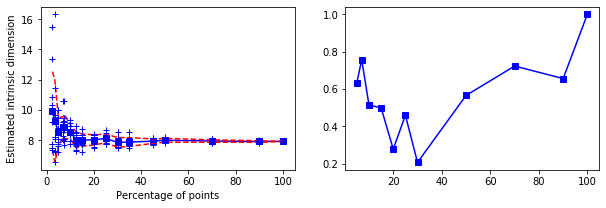

ess_dim_estimates


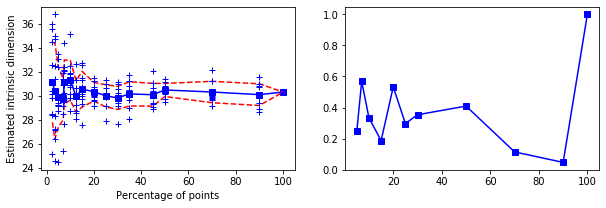

danco_dim_estimates


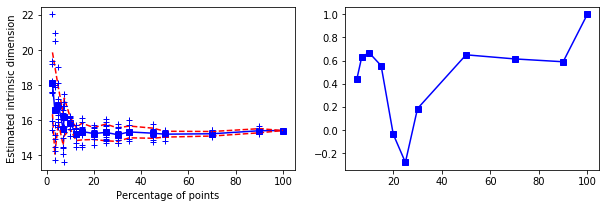

twonn_dim_estimates


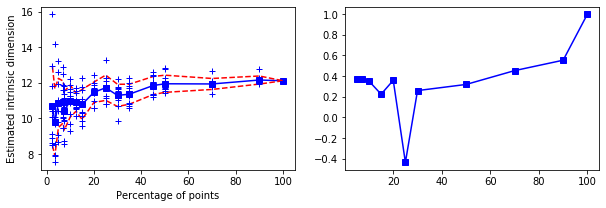

anova_dim_estimates


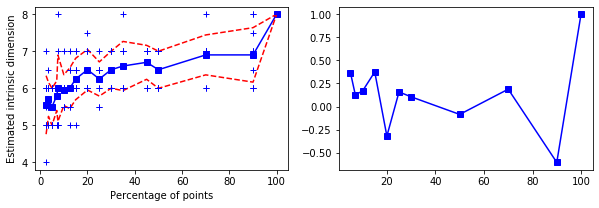

mle_dim_estimates


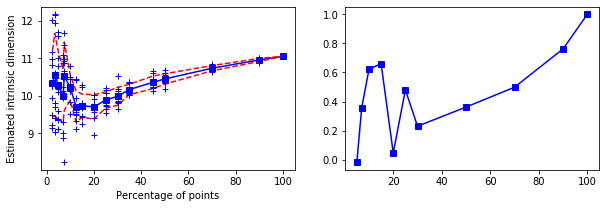

mind_dim_estimates


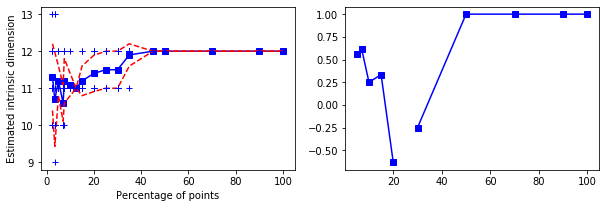

In [22]:
# plot convergence curve
alls=pd.read_csv('../results/'+dataset_name+'_all_sample_sizes.txt', sep='\t',header=None)
all_sample_sizes = alls.to_numpy()[:,0]
sizes=pd.read_csv('../results/'+dataset_name+'_sample_sizes.txt', sep='\t',header=None)
sample_sizes =sizes.to_numpy()[:,0]

estimators = ['fisherS_dim_estimates','ess_dim_estimates','danco_dim_estimates',
              'twonn_dim_estimates','anova_dim_estimates','mle_dim_estimates','mind_dim_estimates']

for estimator in estimators:
    print(estimator)
    ds=pd.read_csv('../results/'+dataset_name+'_'+estimator+'.txt', sep='\t',header=None)
    dim_estimates=ds.to_numpy()

    mn = np.mean(dim_estimates[:,:],1)
    std = np.std(dim_estimates[:,:],1)

    plt.figure(figsize=(10,3))
    plt.subplot(121)
    plt.plot(all_sample_sizes,mn,'bs-')
    plt.plot(all_sample_sizes,mn-std,'r--')
    plt.plot(all_sample_sizes,mn+std,'r--')
    plt.plot(all_sample_sizes,dim_estimates,'b+')
    plt.xlabel('Percentage of points')
    plt.ylabel('Estimated intrinsic dimension')

    ratios = []
    for sz in sample_sizes:
        sz_half = sz/2
        k = [i for i,asz in enumerate(all_sample_sizes) if np.abs(sz-asz)<0.001 ][0]
        k_half = [i for i,asz in enumerate(all_sample_sizes) if np.abs(sz_half-asz)<0.001 ][0]
        #print(k,all_sample_sizes[k],k_half,all_sample_sizes[k_half])
        ratios.append(1-std[k]/std[k_half])
        
    #avoid case of 0 std (nan ratio)
    ratios=np.array(ratios)
    ratios[np.isnan(ratios)]=1

    plt.subplot(122)
    plt.plot(sample_sizes,ratios,'bs-')
    plt.show()

### Study kNN ID

In [27]:
num_neighbors = [100]
n_jobs = 4

#Run ID estimators pointwise in KNN neighborhoods of different sizes
for n_neighbors in num_neighbors:
    for dataset_name,data in [('mnist',mnist_subsampled)]:
    
        n_samples = data.shape[0]
        print(dataset_name)
        print('Running kNN ID for all estimators...\nNumber of samples = {}\nDimension = {}'.format(n_samples,data.shape[1]))
        print('----------------------------\n')
        print('kNN = ',n_neighbors)

        start_all=time.time()

        ests_pw_dict = DE.estimateAllMethodsLocally(data, k = n_neighbors, n_jobs = n_jobs)

        print('elapsed :',round(time.time()-start_all,2))

        with open('../results/ests_pw_dict_'+dataset_name+'_kNN'+str(n_neighbors)+'.pkl','wb') as f:
            pickle.dump(ests_pw_dict,f)

mnist
Running kNN ID for all estimators...
Number of samples = 1000
Dimension = 784
----------------------------

kNN =  100
elapsed : 685.54


In [28]:
with open('../results/ests_pw_dict_'+dataset_name+'_kNN'+str(n_neighbors)+'.pkl','rb') as f:
    res_pw=pickle.load(f)

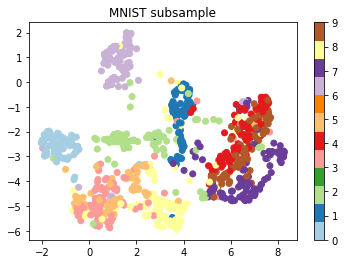

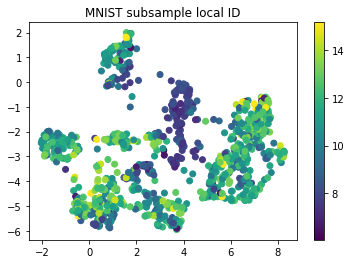

In [52]:
np.random.seed(0);umap_emb = umap.UMAP().fit_transform(mnist_subsampled)
plt.scatter(umap_emb[:,0],umap_emb[:,1],c=real_data_subsampled_labels,cmap=plt.cm.Paired);plt.title('MNIST subsample');plt.colorbar();plt.show()
plt.scatter(umap_emb[:,0],umap_emb[:,1],c=res_pw[0]['FisherS'],vmax=np.quantile(res_pw[0]['FisherS'],.99));plt.title('MNIST subsample local ID');plt.colorbar();plt.show()

### Study global pointwise ID

In [66]:
list_global_id = []
list_pwglobal = []
for dataset_name,data in [('mnist',mnist_subsampled)]:

    print(dataset_name)
    start_all=time.time()

    [n_alpha,n_single,p_alpha,alphas,separable_fraction,Xp] = SeparabilityAnalysis(data,ProducePlots=0,alphas=np.arange(.2,1,.02)[None])
    n_pointwise, idx = point_inseparability_to_pointID(n_alpha,n_single,p_alpha,alphas,idx='all_separable')

    list_global_id.append(n_single[0])
    list_pwglobal.append(n_pointwise)

    print('elapsed :',round(time.time()-start_all,2))
    
    with open('../results/list_pwglobal_'+dataset_name+'.pkl','wb') as f:
        pickle.dump(list_pwglobal,f)

mnist
elapsed : 1.27


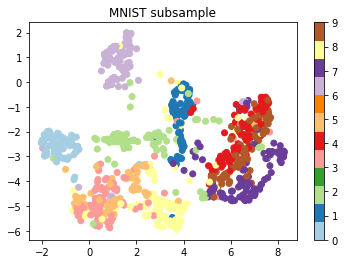

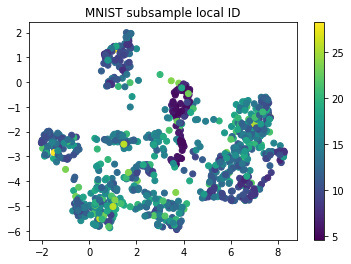

In [69]:
plt.scatter(umap_emb[:,0],umap_emb[:,1],c=real_data_subsampled_labels[:1000],cmap=plt.cm.Paired);plt.title('MNIST subsample');plt.colorbar();plt.show()
plt.scatter(umap_emb[:,0],umap_emb[:,1],c=n_pointwise);plt.title('MNIST subsample local ID');plt.colorbar();plt.show()

### Study the behavior of the statistics used by the various estimators